In [1]:
#import dependencies
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import models, layers
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=40

In [3]:
# dataset load with keras preprocessing 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "G:\Archive\data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 150, 150, 3)
[1 3 0 2 2 0 0 1 1 3 0 3 0 0 1 2 1 1 0 2 3 1 3 3 2 3 2 0 0 1 0 3]


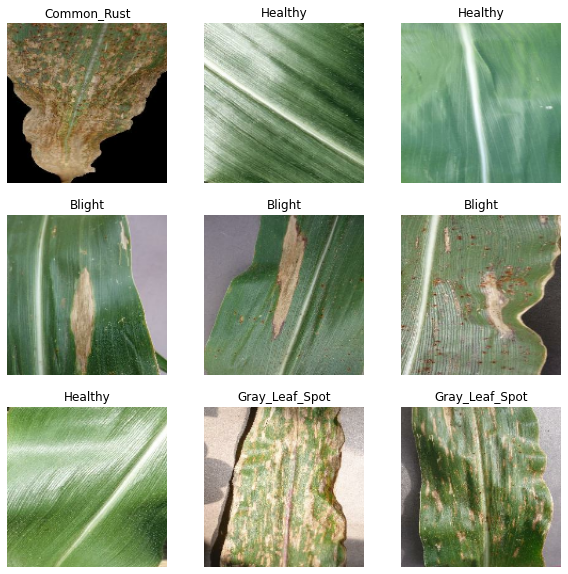

In [6]:
#display a portion of dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.savefig("Train dataset.png",format="png",facecolor="white")
        plt.axis("off")

In [7]:
#split the dataset into train, test & validatoin set

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=.05,test_split=0.15, shuffle=True, shuffle_size=1000):
    assert (train_split +val_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds, test_ds

In [8]:
train_ds,val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

104

In [10]:
len(val_ds)

6

In [11]:
len(test_ds)

21

In [12]:
# cache dataset into memory, shuffle, prepare next batch of data while model is executing previous batch 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [16]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.BatchNormalization(input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 148, 148, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 148, 148, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 74, 74, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 74, 74, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 72, 72, 64)         

In [19]:
#adapt learning rate

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
   validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
104/104 [==============================] - 142s 1s/step - loss: 0.7309 - accuracy: 0.7563 - val_loss: 1.2750 - val_accuracy: 0.4062
Epoch 2/40
104/104 [==============================] - 100s 959ms/step - loss: 0.3363 - accuracy: 0.8532 - val_loss: 1.8314 - val_accuracy: 0.3854
Epoch 3/40
104/104 [==============================] - 101s 967ms/step - loss: 0.2662 - accuracy: 0.8956 - val_loss: 2.2440 - val_accuracy: 0.3073
Epoch 4/40
104/104 [==============================] - 101s 974ms/step - loss: 0.2261 - accuracy: 0.9076 - val_loss: 0.6975 - val_accuracy: 0.7240
Epoch 5/40
104/104 [==============================] - 103s 989ms/step - loss: 0.1982 - accuracy: 0.9224 - val_loss: 0.4738 - val_accuracy: 0.8125
Epoch 6/40
104/104 [==============================] - 101s 971ms/step - loss: 0.1471 - accuracy: 0.9461 - val_loss: 0.2321 - val_accuracy: 0.9271
Epoch 7/40
104/104 [==============================] - 102s 985ms/step - loss: 0.1299 - accuracy: 0.9483 - val_loss: 0.1698 - va

In [21]:
scores = model.evaluate(test_ds)
scores

21/21 [==============================] - 27s 251ms/step - loss: 0.1261 - accuracy: 0.9836


[0.12609583139419556, 0.9836309552192688]

In [22]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 104}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
len(history.history['loss'])

40

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

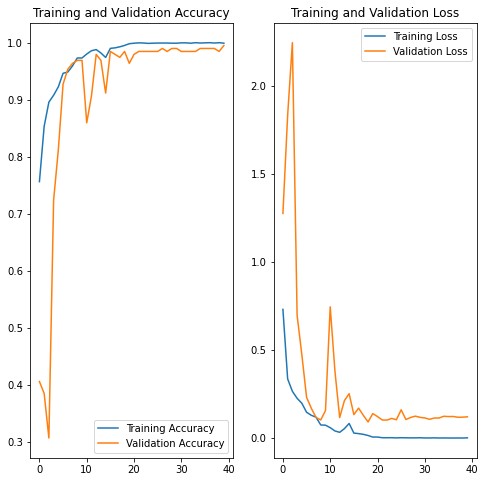

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Common_Rust
1/1 [==============================] - 0s 255ms/step
predicted label: Common_Rust


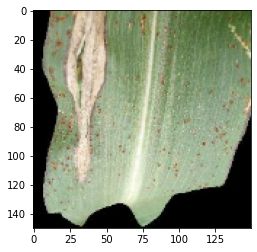

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


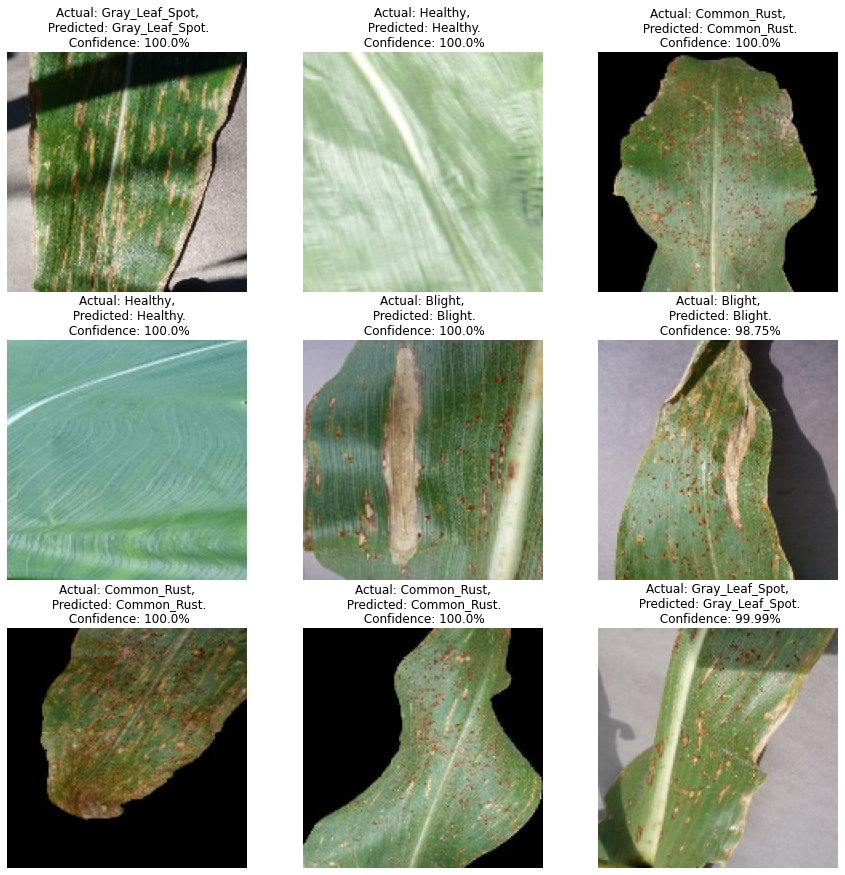

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.savefig('Test Dataset Prediction Using The Trained Model.png',format='png',facecolor='white')
        plt.axis("off")

In [30]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
predicted_labels = []
true_labels = []

In [ ]:
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1))
    true_labels.extend(labels)

In [32]:
predicted_labels = tf.stack(predicted_labels, axis=0).numpy()
true_labels = tf.stack(true_labels, axis=0).numpy()

In [33]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

In [34]:
precision,recall,f1, accuracy

(0.9837471911664192,
 0.9836309523809523,
 0.9836374497892231,
 0.9836309523809523)

In [35]:
pre = round(100 * precision,2)
re = round(100 * recall,2)
f = round(100 * f1,2)
accu = round(100 * accuracy,2)

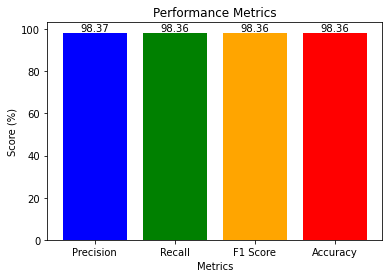

In [46]:
labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [pre, re ,f , accu]


plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('Performance Metrics')
plt.savefig("Performance Metrics.png", format='png',facecolor = "white")
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_labels,predicted_labels)

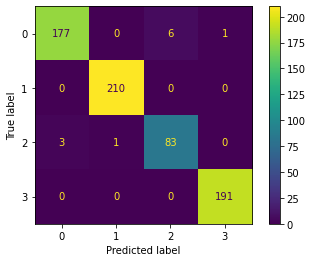

In [47]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [41]:
import pickle
pickle.dump(model,open("maize_leave_detection_model_98.36.pkl","wb"))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...layers\max_pooling2d_3
......vars
...layers\sequential
......vars
...layers\sequential\layers\rescaling
......vars
...layers\sequential\layers\resizing
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimiz

In [40]:
import pickle
#model = pickle.load(open("maize_leave_detection_model_99.11.pkl","rb"))